In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import torch


In [2]:
# loading dataframe using pandas

import os 

path_dir = '/kaggle/input/framingham-dataset/'
filename = "framingham.csv"
file_path = os.path.join(path_dir, filename)

disease_df = pd.read_csv(file_path)
disease_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


In [3]:
## data preprocessing

disease_df.drop(['education'], inplace = True, axis = 1)
disease_df.rename(columns ={'male':'Sex_male'}, inplace = True)
disease_df.dropna(axis = 0, inplace = True)

disease_df.head()

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# number of samples in each class (either possible or not possible) 

print(disease_df.TenYearCHD.value_counts())

TenYearCHD
0    3179
1     572
Name: count, dtype: int64


In [5]:
## converting dataframe into numpy arrays for further computation

X = np.asarray(disease_df[['age', 'Sex_male', 'cigsPerDay', 
                           'totChol', 'sysBP', 'glucose']])
y = np.asarray(disease_df['TenYearCHD'])

X = preprocessing.StandardScaler().fit(X).transform(X)


## train-test split - (70% - 30% ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size = 0.3, random_state = 4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (2625, 6) (2625,)
Test set: (1126, 6) (1126,)


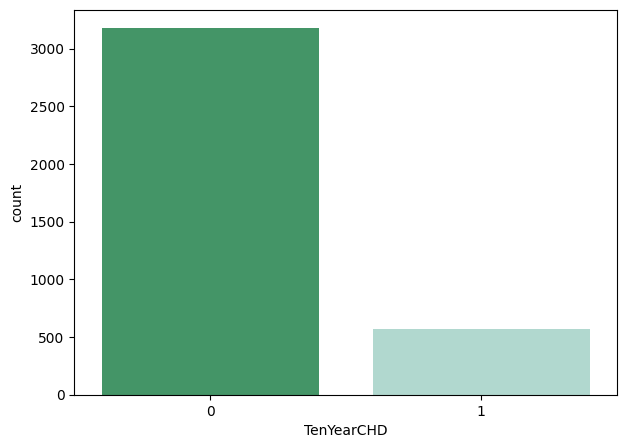

In [6]:
plt.figure(figsize=(7, 5))
sns.countplot(x='TenYearCHD', data=disease_df, palette="BuGn_r")
plt.show()


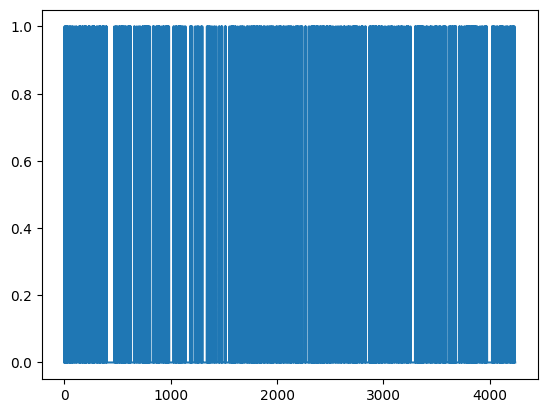

In [7]:
laste = disease_df['TenYearCHD'].plot()
plt.show(laste)

In [8]:
# defining model 

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        """ Sigmoid activation function """
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_predicted):
        """ Compute Binary Cross-Entropy (Log Loss) """
        n_samples = len(y)
        loss = - (1 / n_samples) * np.sum(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted))
        return loss

    def fit(self, X, y):
        """ Train the logistic regression model """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Initialize weights with zeros
        self.bias = 0  # Initialize bias as 0

        for i in range(self.epochs):
            # Compute the linear combination of weights and inputs
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute loss (log loss)
            loss = self.compute_loss(y, y_predicted)
            if i % 100 == 0:  # Print loss every 100 epochs
                print(f'Epoch {i}: Log Loss = {loss:.4f}')

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))  # Partial derivative w.r.t. weights
            db = (1 / n_samples) * np.sum(y_predicted - y)  # Partial derivative w.r.t. bias

            # Update weights and bias using Gradient Descent
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """ Predict class labels (0 or 1) """
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]  # Convert probabilities to binary labels


# initilaizing model
model = LogisticRegressionScratch(learning_rate=0.001, epochs=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Epoch 0: Log Loss = 0.6931
Epoch 100: Log Loss = 0.6796
Epoch 200: Log Loss = 0.6668
Epoch 300: Log Loss = 0.6546
Epoch 400: Log Loss = 0.6430
Epoch 500: Log Loss = 0.6320
Epoch 600: Log Loss = 0.6215
Epoch 700: Log Loss = 0.6116
Epoch 800: Log Loss = 0.6022
Epoch 900: Log Loss = 0.5932


In [9]:
## using inbuilt logistic regression function

# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)


In [10]:
## in-built accuracy function to find accuracy of model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy of the model is = {accuracy_score(y_test, y_pred)*100 : .5f}")
print(f"Precision of the model is = {precision_score(y_test, y_pred)*100 : .5f}")
print(f"Recall of the model is = {recall_score(y_test, y_pred)*100 : .5f}")
print(f"F1-score of the model is = {f1_score(y_test, y_pred)*100 : .5f}")


Accuracy of the model is =  84.99112
Precision of the model is =  66.66667
Recall of the model is =  6.85714
F1-score of the model is =  12.43523


The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       951
           1       0.67      0.07      0.12       175

    accuracy                           0.85      1126
   macro avg       0.76      0.53      0.52      1126
weighted avg       0.82      0.85      0.79      1126



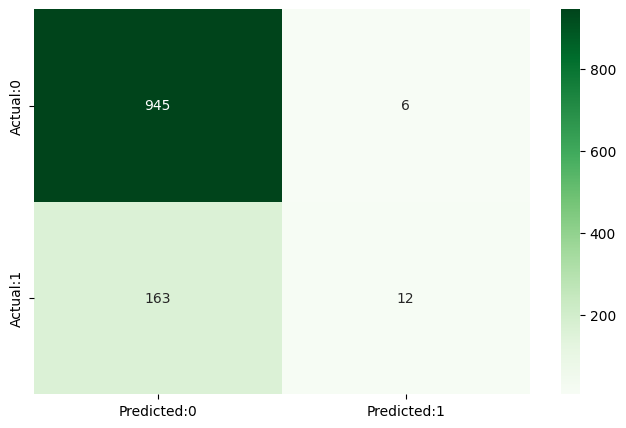

In [11]:
## representing confusion matrix as heatmap 
## heatmap - representing smaples per cell with intensity of color representing the number of samples

from sklearn.metrics import confusion_matrix, classification_report

print('The details for confusion matrix is =')
print (classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])

plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens")

plt.show()
